In [17]:
import torch
import torchaudio as ta
import torchmetrics.classification as tc
from torch.utils.data import Dataset
import torchvision as tv
import pandas as pd
import os
import numpy as np
from itertools import compress
import librosa
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torchaudio.transforms import Spectrogram
import torchvision.transforms as transforms
import random
import torchaudio.functional as AF
import torch.nn.functional as F
import torchaudio.transforms as T
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
CUDA_LAUNCH_BLOCKING=1
TORCH_USE_CUDA_DSA = 1
%load_ext tensorboard


In [2]:
# Method to move tensors to chosen device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
class SpectroDataset(Dataset):
    def __init__(self, 
                recording_path: List[str], 
                label_path: List[str],
                #  transform: None | Callable,
                sampling_rate: int = 44100, #Hz
                loudness: int = 10,
                device = 'cpu',
                **kwargs):
        self.l_path = label_path
        self.r_path = recording_path

        dir_files = os.listdir(label_path)
        soundscape_file = os.path.join(self.l_path, list(compress(dir_files, [file.endswith("_single.parquet") for file in dir_files]))[0])
        sound_df = pd.read_parquet(soundscape_file)
        sound_df = sound_df.drop(sound_df.loc[sound_df.label.isna()].index)

        dir_files = os.listdir(recording_path)
        dir_files = list(compress(dir_files, [file.endswith(".flac") for file in dir_files]))

        dir_files = [int(f.split('_')[0]) for f in dir_files]

        recording_df = pd.DataFrame({"id":dir_files})

        self.file_df = sound_df.merge(recording_df)
        
        self.fileNames = self.file_df.id.values
        self.fileLabels = self.file_df.label.values
        # self.transforms = transform
        self.sampling_rate = sampling_rate
        self.loudness = loudness
        self.device = device
    
    def __len__(self):
        return len(self.fileNames)
    
    def __getitem__(self, idx):
        #x = torch.zeros(10*self.sr)
        print("Getting", os.path.join(self.r_path, (str(self.fileNames[idx])+"_audio.flac")))
        # Uses native sampling rate of the file
        # Normalize arg does bit depth normalization
        # Move to device specified
        wave, sr = ta.load(uri=os.path.join(self.r_path, (str(self.fileNames[idx])+"_audio.flac")))#, normalize=True)
        
        # Move to specified device, e.g. GPU
        wave = wave.to(torch.float32)
        
        # Resample to the sampling rate given by the args 
        if sr != self.sampling_rate:
            print(f"Initial sampling rate is {sr}, resampling to {self.sampling_rate}")
            wave = ta.functional.resample(wave, sr, self.sampling_rate)

        # LUFS normalization to a given loudness
        wave_loudness = AF.loudness(wave, self.sampling_rate)
        gain = self.loudness - wave_loudness
        multiplier = 10 ** (gain/20)
        wave = wave * multiplier
        
        # for testing sample only seconds 10 to 20
        llimit = int(self.sampling_rate * 10)
 
        wave = wave[:, int(llimit):int(llimit*2)]

        # most of the time the first and last 10 seconds should be cut off 
        # wave = wave[:, int(llimit):int(llimit*5)+1]

        # Squeeze to go from 1,x to x shape tensor
        wave = to_device(wave.squeeze(), self.device)
        return wave, sr, int(self.fileLabels[idx])

In [5]:
ds = SpectroDataset("Z:\\Audio_data\\Dawn_chorus_conversion_flac", os.getcwd(), device = 'cuda')

In [6]:
def splitDataset(dataset, test_split_size = 0.2, val_split_size = 0.1):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))

    test_split = int(np.floor(test_split_size * dataset_size))
    val_split = int(np.floor(val_split_size * dataset_size))

    val_indices, test_indices, train_indices = indices[:val_split], indices[val_split: (val_split+test_split)], indices[(val_split+test_split):]

    return train_indices, test_indices, val_indices 


In [7]:
train_indices, test_indices, val_indices  = splitDataset(ds)

In [57]:
class SpectroDataLoader():
    """
    """

    def __init__(self, datas, batch_size, samples, device='cpu'):
        self.waves = []
        self.lbs = []
        self.sr = []
        self.device = device

        # Append to each array the values returned in the dataset class (wave, sampling_rate, label)
        for idx in samples:
            print(idx)
            elem=datas[idx]
            self.waves.append(elem[0])
            self.sr.append(elem[1])
            self.lbs.append(elem[-1])

        # Shuffle all waves
        self.datas = list(zip(self.waves, self.lbs))
        random.shuffle(self.datas)

        # Attributes for batching
        self.batch_size = batch_size
        self.image_batches = []
        self.label_batches = []

        while (len(self.datas) / self.batch_size > 0) | (len(self.datas) % self.batch_size != 0):

            # first n entries of shuffled vector are batch
            batch = self.datas[:self.batch_size]

            wvs = []
            las = []

            # Need to separate images and labels into two tensors
            for wv, la in batch:
                wvs.append(wv)
                las.append(la)
            del self.datas[:self.batch_size]

            le = LabelEncoder()
            lef = le.fit(las)
            las = lef.transform(las)

            self.image_batches.append(wvs)
            self.label_batches.append(las)

    def __iter__(self):
        bat = list(zip(self.image_batches, self.label_batches))
        random.shuffle(bat)

        # return a random batch
        for image_batch, label_batch in bat:
            yield to_device([torch.stack(image_batch), torch.Tensor(label_batch)], self.device)

    def __len__(self):
        return len(self.image_batches)


In [58]:
batch_size = 8
train_dataloader = SpectroDataLoader(ds, batch_size, samples= train_indices[:150], device = "cuda")

13119
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23853551_audio.flac
13120
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23853553_audio.flac
13121
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23862849_audio.flac
13122
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\24104283_audio.flac
13123
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\25408667_audio.flac
13124
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26172099_audio.flac
13125
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26563106_audio.flac
13126
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26747817_audio.flac
13127
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26755651_audio.flac
13128
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26783670_audio.flac
13129
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26822314_audio.flac
13130
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26831857_audio.flac
13131
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26834562_audio.flac
13132
Gettin

In [61]:
val_dataloader = SpectroDataLoader(ds, batch_size, samples= val_indices[:150], device = "cuda")

0
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19068740_audio.flac
1
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19096975_audio.flac
2
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19115260_audio.flac
3
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19126725_audio.flac
4
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19133357_audio.flac
5
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19137487_audio.flac
6
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19139784_audio.flac
7
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19148979_audio.flac
8
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19152848_audio.flac
9
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19162286_audio.flac
10
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19202771_audio.flac
11
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19250699_audio.flac
12
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19754493_audio.flac
13
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19754487

In [62]:
test_dataloader = SpectroDataLoader(ds, batch_size, samples= test_indices[:150], device = "cuda")

4373
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21473304_audio.flac
4374
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21502802_audio.flac
4375
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21525865_audio.flac
4376
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21556705_audio.flac
4377
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21568713_audio.flac
4378
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21586206_audio.flac
4379
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21630314_audio.flac
4380
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21689604_audio.flac
4381
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21725964_audio.flac
4382
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21741886_audio.flac
4383
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21761018_audio.flac
4384
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21762672_audio.flac
4385
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21817477_audio.flac
4386
Getting Z:\Audio_dat

In [11]:
class AudioToLogSpectrogram(torch.nn.Module):
    def __init__(
        self,
        n_fft=4096,
        scale=1,
        device="cpu"
    ):
        super().__init__()
        
        self.scale = scale
        self.spec = to_device(ta.transforms.Spectrogram(n_fft=n_fft, hop_length=n_fft//4, power=2), device)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Resample
        # waveform = ta.transforms.resample()

        # Convert to power spectrogram
        spec = self.spec(waveform)
        
        spec = torch.where(spec < 1, 1, spec)
        spectrogram = torch.log10(spec) / self.scale
        im = transforms.Resize((224, 224))(spectrogram[None, :, :]).squeeze()
        return im.unsqueeze(1)

In [12]:
atls = AudioToLogSpectrogram(device = "cuda")

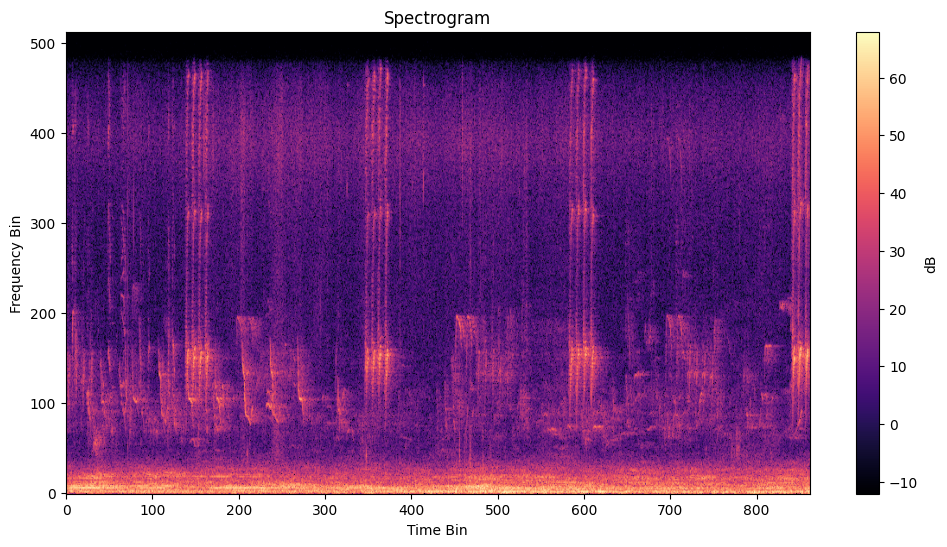

In [13]:
waveform = next(iter(train_dataloader))[0][1]

spectrogram_transform = T.Spectrogram(
    n_fft=1024, 
    hop_length=512, 
    power=2
)

spec = spectrogram_transform(waveform.cpu()) 

spec_db = T.AmplitudeToDB(stype='power', top_db=80)(spec)

plt.figure(figsize=(12, 6))
plt.imshow(
    spec_db.numpy(), 
    origin='lower', 
    aspect='auto', 
    cmap='magma'
)
plt.colorbar(label='dB')
plt.title("Spectrogram")
plt.ylabel("Frequency Bin")
plt.xlabel("Time Bin")
plt.show()

In [14]:
res = tv.models.resnet18()
adaptconv1 = nn.Conv2d (in_channels=1, kernel_size=res.conv1.kernel_size, stride=res.conv1.stride, padding = res.conv1.padding, bias=res.conv1.bias, out_channels=res.conv1.out_channels)
res.conv1 = adaptconv1
res.fc = nn.Linear(in_features=res.fc.in_features, out_features=37, bias=True)

nnw = nn.Sequential(atls, res)

to_device(nnw, device)

Sequential(
  (0): AudioToLogSpectrogram(
    (spec): Spectrogram()
  )
  (1): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchN

In [81]:
# https://medium.com/biased-algorithms/a-practical-guide-to-implementing-early-stopping-in-pytorch-for-model-training-99a7cbd46e9d
class EarlyStopping:
    def __init__(self, model, patience=5, delta=0.001, path='checkpoints/checkpoint.pt', verbose=True):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.model = model
    
    def check_early_stop(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
            # Save checkpoint if improvement observed
            torch.save(self.model.state_dict(), self.path)
            if self.verbose:
                print(f"Model improved; checkpoint saved at loss {val_loss:.4f}")
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                print("Early stopping triggered.")
                return True  # Signal to stop training
        return False

In [ ]:
epochs = 400
batch_prints = batch_size
writer = SummaryWriter("runs/single_points")
lr = 0.001# 0.0001 

# Parameters for the ElasticNet penalty
l1_lambda = 0.002
l2_lambda = 0.0015

loss = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=7, delta=0.01, model = nnw)

# fused doesn't work without cuda
if device == 'cuda':
    optimizer = optim.Adam(nnw.parameters(), lr=lr, fused=True)
else:
    optimizer = optim.Adam(nnw.parameters(), lr=lr)

# Train the network
for epoch in range(epochs):  # loop over the dataset multiple times
    nnw.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        outputs = nnw(inputs)

        labels_long = labels.type(torch.LongTensor)
        labels_long = to_device(labels_long.long(), device)
        print(f"Batch Label Min: {labels_long.min()}, Max: {labels_long.max()}")

        los = loss(outputs, labels_long)


        l1_penalty = 0
        l2_penalty = 0

        # L1 and L 2Regularization
        for p in nnw.parameters():
            l1_penalty += p.abs().sum()
            l2_penalty += p.pow(2.0).sum()

        # Elastic Net Penalty
        elastic_penalty = l1_lambda * l1_penalty + l2_lambda * l2_penalty

        los += elastic_penalty

        # Clear the gradients
        optimizer.zero_grad()

        # Backpropagation to compute gradients
        los.backward()

        # Update model parameters
        optimizer.step()

        # print statistics
        running_loss += los.item()
        if i % batch_prints == (batch_prints-1):  # print every 16 mini-batches
            
            # Check against validation dataset
            running_vloss = 0.0

            # Switch to evaluation mode to omit some model specific operations like dropout
            nnw.train(False)
            for j, vdata in enumerate(val_dataloader, 0): 
                vinputs, vlabels = vdata
                vlabels_long = to_device(vlabels.type(torch.LongTensor), device)
                voutputs = nnw(vinputs)
                vloss = loss(voutputs, vlabels_long)
                running_vloss  +=vloss.item()
            
            nnw.train(True)
            avg_loss = running_loss / batch_prints

            avg_vloss = running_vloss / len(val_dataloader)

            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(train_dataloader) + i)

            print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.6f} vloss: {avg_vloss:.6f}')

            running_loss = 0.0
        
        
    if early_stopping.check_early_stop(avg_vloss):
        print(f"Stopping training at epoch {epoch+1}")
        break

nnw.eval()
print('Finished Training')

writer.flush()
print("Flushed writer")

Batch Label Min: 0, Max: 4
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 3
Batch Label Min: 0, Max: 3
Batch Label Min: 0, Max: 3
Batch Label Min: 0, Max: 4
Batch Label Min: 0, Max: 2
[1,     8] loss: 9.830415 vloss: 1.722666
Model improved; checkpoint saved at loss 1.7227
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 3
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 3
Batch Label Min: 0, Max: 2
[1,    16] loss: 4.881182 vloss: 1.548710
Model improved; checkpoint saved at loss 1.5487
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 4
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 3
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 2
Batch Label Min: 0, Max: 2
[2,     8] loss: 4.406277 vloss: 1.639461
Batch Label Min: 0, Max: 3
Batch Label Min: 0, Ma

In [65]:
%tensorboard --logdir runs/single_points/

Reusing TensorBoard on port 6008 (pid 22976), started 0:40:12 ago. (Use '!kill 22976' to kill it.)

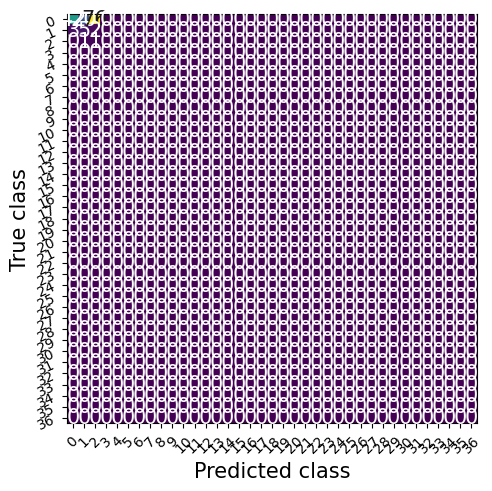

Recall of the custom cnn: tensor(0.4348, device='cuda:0')
F1-score of the custom cnn: tensor(0.2538, device='cuda:0')
Overall accuracy of the custom cnn: tensor(0.4348, device='cuda:0')


In [70]:
preds = torch.Tensor().to(device)
labs = torch.Tensor().to(device)

# Get predictions and corresponding real labels
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        inp = nnw(inputs)

        preds = torch.cat((preds, inp), 0).to(device)
        labs = torch.cat((labs, labels), 0)
        labs = labs.type(torch.LongTensor).to(device)


# Confusion Matrix
metric = tc.MulticlassConfusionMatrix(37).to(device)
metric.update(preds, labs)

fig_, ax_ = metric.plot()
plt.show()


# Compute recall
recall = tc.Recall(task="multiclass", average='macro', num_classes=37).to(device)
recall(preds, labs)
print("Recall of the custom cnn:", recall.compute())

# Compute F1-score
f1 = tc.MulticlassF1Score(37).to(device)
f1(preds, labs)
print("F1-score of the custom cnn:", f1.compute())


# Compute overall accuracy
oa = tc.MulticlassAccuracy(37).to(device)
oa(preds, labs)
print("Overall accuracy of the custom cnn:", oa.compute())